## 0a. import liblaries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pulp import *

## 0b. load data

In [4]:
distances = pd.read_csv("Distances.csv")

In [5]:
distances = distances.drop("Unnamed: 0", axis=1)
distances = distances.set_index('Unnamed: 1')
distances = distances[distances.index.notnull()]
distances

,BS16 5TR,BS8 4HY,BS4 2NZ,BS35 3RY,BS3 3NA,BS29 6AB,BS10 6DQ,BS25 1TW,BS16 4DD,BS10 5DB,BS48 3RE,BS37 6RX,BS13 8BW,BS5 8EJ
Unnamed: 1,,,,,,,,,,,,,,
BS16 5TR,0.00,8.16,7.85,8.85,8.56,29.96,6.44,22.39,1.80,5.95,13.01,6.92,10.83,3.09
BS8 4HY,8.28,0.00,4.33,10.60,2.87,20.23,4.07,15.03,5.51,3.92,5.65,15.53,4.36,3.86
BS4 2NZ,7.63,4.87,0.00,13.04,2.93,17.66,6.57,15.87,4.46,5.24,7.98,13.60,5.13,2.49
BS35 3RY,8.88,15.10,13.62,0.00,13.41,25.83,7.44,29.49,9.99,6.81,16.48,14.74,17.84,12.09
BS3 3NA,8.57,2.37,2.63,13.09,0.00,15.25,7.33,13.46,5.80,5.93,5.48,15.82,2.26,4.24
BS29 6AB,30.64,16.68,17.51,26.27,15.15,0.00,24.67,3.96,31.75,25.89,13.26,36.51,13.88,33.85
BS10 6DQ,6.30,3.99,7.12,7.42,7.71,23.97,0.00,19.87,7.41,1.78,1.05,13.57,9.21,5.58
BS25 1TW,22.77,14.89,15.71,29.94,13.36,3.96,19.85,0.00,20.00,18.44,11.46,30.02,12.09,18.12
BS16 4DD,1.53,5.48,4.74,9.92,5.87,31.04,5.70,19.71,0.00,4.37,10.33,8.42,8.18,1.95


## 1.  Construct a delivery route for one lorry by starting at the base (BS16 5TR) and consistenly visiting the nearest non-visited remaining address until all addresses are visited and then going back to base. What is the total distance that is travelled?

In [6]:
home = "BS16 5TR"
base = "BS16 5TR"
total_distance = 0;
i = 0;
distances_editable = distances.copy()
while (i < len(distances.columns)-1):
    shortest_path = distances_editable.loc[base,:][distances_editable.loc[base,:] > 0.0].min()
    new_destination = distances_editable.loc[base,:][distances_editable.loc[base,:] > 0.0].idxmin()
    total_distance += shortest_path
    distances_editable = distances_editable.drop(base,axis=1)
    i += 1
    base = new_destination
    
# go back home
total_distance += distances.loc[base,home]

print("total distance: ", total_distance, "km")
print("CORRECT")

total distance:  86.27 km
CORRECT


## 2. What is the best route for a single lorry to deliver products to all of the addresses? How does it compare to the ”Nearest Neighbour” approach?

In [14]:
# convert column names of pandas 'dataframe' into a python list
adresses = distances.columns.tolist()

In [15]:
# Create the 'prob' variable to contain the problem data
prob = LpProblem("Shortest path - basic",LpMinimize)

In [16]:
# A dictionary called 'adress_vars' is created to contain the referenced Variables
adresses_vars = LpVariable.dicts("path",(adresses,adresses),0,1,LpInteger)

In [17]:
# The objective function
prob += lpSum([distances.loc[i,j]*adresses_vars[i][j] 
               for i in adresses
               for j in adresses]), "Total distance"

#### Add constraints

In [18]:
# each node can have only one edge out and one edge in
for i in adresses:
    prob += lpSum([adresses_vars[i][j] for j in adresses]) == 1, ("one edge out per " + i)
    prob += lpSum([adresses_vars[j][i] for j in adresses]) == 1, ("one edge in per node" + i)

    # no node can lead to itself
    prob += adresses_vars[i][i] == 0, ("no going to itself" + i)

# eliminate sub-loops 
for i in adresses:
    for j in adresses:
        prob += adresses_vars[j][i] + adresses_vars[i][j] <= 1, ("avoid 2-loops" + i + "_" + j)
    
prob.solve()

1

In [19]:
print("Total distance: ", value(prob.objective))
print("correct values is: 75.84")

Total distance:  75.84000000000002
correct values is: 75.84


#### Use following code to find sub-loops

In [20]:
distances_copy = distances.copy()
distances_copy.iloc[:,:] = 0
for v in prob.variables():    
    if (v.varValue > 0.0):
        adress_array = v.name.split('_')
        from_ = adress_array[1] + " " + adress_array[2]
        to_ = adress_array[3] + " " + adress_array[4]
        distances_copy.loc[from_,to_] = 1

In [21]:
# calculate "binary matrix" of variables to the power of n (for n = [1:14])

distances_p2 = distances_copy.dot(distances_copy)
distances_p3 = distances_p2.dot(distances_copy)
distances_p4 = distances_p3.dot(distances_copy)
distances_p5 = distances_p4.dot(distances_copy)
distances_p6 = distances_p5.dot(distances_copy)
distances_p7 = distances_p6.dot(distances_copy)
distances_p8 = distances_p7.dot(distances_copy)
distances_p9 = distances_p8.dot(distances_copy)
distances_p10 = distances_p9.dot(distances_copy)
distances_p11 = distances_p10.dot(distances_copy)
distances_p12 = distances_p11.dot(distances_copy)
distances_p13 = distances_p12.dot(distances_copy)
distances_p14 = distances_p13.dot(distances_copy)

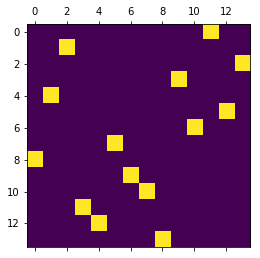

In [22]:
plt.matshow(distances_copy.iloc[:,:] == 1)
plt.show()

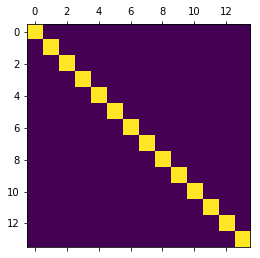

In [23]:
plt.matshow(distances_p14.iloc[:,:] == 1)
plt.show()

#### above matrix is diagonal which indicates that all nodes come back to itself after 14 steps

## 3.  What are the best routes if you have two lorries?

In [24]:
# Create the 'prob' variable to contain the problem data
prob_2 = LpProblem("Shortest path - 2 lorries",LpMinimize)

# A dictionary called is created to contain the referenced Variables
adress_vars = LpVariable.dicts("path",(adresses,adresses),0,1,LpInteger)

# The objective function
prob_2 += lpSum([distances.loc[i,j]*adress_vars[i][j] 
               for i in adresses
               for j in adresses]), "Total distance"

In [25]:
# ADD CONSTRAINTS

# node (1,1) (our starting location) can have 2 edges out and 2 edges in (as there are two lorries living it)
prob_2 += lpSum([adress_vars[adresses[0]][j] for j in adresses]) == 2, ("two edges out from the starting location")
prob_2 += lpSum([adress_vars[i][adresses[0]] for i in adresses]) == 2, ("two edges in to the starting location")

# each remaining node can have only one edge out and one edge in
for i in adresses[1:]:
    prob_2 += lpSum([adress_vars[i][j] for j in adresses]) == 1, ("one edge out per " + i)
    prob_2 += lpSum([adress_vars[j][i] for j in adresses]) == 1, ("one edge in per node" + i)

# no node can lead to itself    
for i in adresses:
    prob_2 += adress_vars[i][i] == 0, ("no going to itself" + i)

# eliminate sub-loops 
for i in adresses[1:]:
    for j in adresses[1:]:
        prob_2 += adress_vars[j][i] + adress_vars[i][j] <= 1, ("avoid 2-loops" + i + "_" + j)
    
prob_2.solve()

1

In [26]:
# The status of the solution is printed to the screen
print("Status:", LpStatus[prob.status])

# Each of the variables is printed with it's resolved optimum value
for v in prob.variables():
#     print(v.name, "=", v.varValue)
    if (v.varValue > 0.0):
        print(v.name, "=", v.varValue)

Status: Optimal
path_BS10_5DB_BS10_6DQ = 1.0
path_BS10_6DQ_BS48_3RE = 1.0
path_BS13_8BW_BS3_3NA = 1.0
path_BS16_4DD_BS16_5TR = 1.0
path_BS16_5TR_BS37_6RX = 1.0
path_BS25_1TW_BS29_6AB = 1.0
path_BS29_6AB_BS13_8BW = 1.0
path_BS35_3RY_BS10_5DB = 1.0
path_BS37_6RX_BS35_3RY = 1.0
path_BS3_3NA_BS8_4HY = 1.0
path_BS48_3RE_BS25_1TW = 1.0
path_BS4_2NZ_BS5_8EJ = 1.0
path_BS5_8EJ_BS16_4DD = 1.0
path_BS8_4HY_BS4_2NZ = 1.0


In [27]:
print("Total distance: ", value(prob_2.objective))
print("correct values is:  76.74")

Total distance:  76.74000000000002
correct values is:  76.74


## 4. What are the best routes if you have two lorries, each with a capacity of 10?

#### In this solution we introduce a new dimenison: 'lorry_no' (lorry number) which can take either value '1' or '2'. This variable will indicate which lorry has visited which adress. 
Following are some guidlines needed for constructing constrains:
* First adress is visited by both lorries
* only one lorry can visit all other adresses
* for a given location the lorry that entered a location has to be the one that left it.
* single lorry can visit at most 10 locations



In [51]:
lorry_no = ['1','2']

# Create the 'prob' variable to contain the problem data
prob_3 = LpProblem("Shortest path - 2 lorries",LpMinimize)

# A dictionary called is created to contain the referenced Variables
adresses_vars_3 = LpVariable.dicts("path",(adresses,adresses,lorry_no),0,1,LpInteger)

# The objective function
prob_3 += lpSum([distances.loc[i,j]*adresses_vars_3[i][j][k] 
               for i in adresses
               for j in adresses
                for k in lorry_no]), "Total distance"

In [52]:
# ADD CONSTRAINTS

# node (1,1) (our starting location) can have 2 edges out and 2 edges in (as there are two lorries living it)
# however each edge in or out has to be associated with different lorry
for k in lorry_no:
    prob_3 += lpSum([adresses_vars_3[adresses[0]][j][k] for j in adresses]) == 1, ("two edges out from the starting location" + k)
    prob_3 += lpSum([adresses_vars_3[i][adresses[0]][k] for i in adresses]) == 1, ("two edges in to the starting location" + k)

# each node can have only one edge out and one in
for i in adresses[1:]:
    prob_3 += lpSum([adresses_vars_3[i][j][k] for j in adresses for k in lorry_no]) == 1, ("one edge out per " + i)
    prob_3 += lpSum([adresses_vars_3[j][i][k] for j in adresses for k in lorry_no]) == 1, ("one edge in per node" + i)

# each lorry can visit only 10 adresses at maximum + 1 path to get back home = 11
for k in lorry_no:
    prob_3 += lpSum([adresses_vars_3[j][i][k] for i in adresses for j in adresses]) <= 11, ("each lorry has capacity max 10" + k)

    
# the lorry that left an adress has to be the same one the came in
for i in adresses[1:]:
    for k in lorry_no:
        prob_3 += lpSum([adresses_vars_3[i][j][k] for j in adresses]) == lpSum([adresses_vars_3[j][i][k] for j in adresses]), ("ensure same lorry drives in and out: " + i + "_" + k)

# no node can lead to itself    
for k in lorry_no:
    for i in adresses:
        prob_3 += adresses_vars_3[i][i][k] == 0, ("no going to itself" + i +"_" + k)

#  eliminate 2-node sub-loops 
for k in lorry_no:
    for i in adresses:
        for j in adresses:
            prob_3 += adresses_vars_3[j][i][k] + adresses_vars_3[i][j][k] <= 1, ("avoid 2-loops" + i + "_" + j + "_" + k)
            

# eliminate some manually detected 3-node sub-loops
adresses_sub = ['BS13 8BW', 'BS25 1TW', 'BS29 6AB']
for k in lorry_no:
    prob_3 += lpSum([adresses_vars_3[j][i][k] for i in adresses_sub for j in adresses_sub]) <= 2, ("avoid 3-loop - a" + k)

adresses_sub_2 = ['BS16 5TR', 'BS37 6RX', 'BS16 4DD']
for k in lorry_no:
    prob_3 += lpSum([adresses_vars_3[j][i][k] for i in adresses_sub_2 for j in adresses_sub_2]) <= 2, ("avoid 3-loop - b" + k)
    
adresses_sub_3 = ['BS16 5TR', 'BS35 3RY', 'BS37 6RX']
for k in lorry_no:
    prob_3 += lpSum([adresses_vars_3[j][i][k] for i in adresses_sub_3 for j in adresses_sub_3]) <= 2, ("avoid 3-loop - c" + k)

adresses_sub_4 = ['BS16 5TR', 'BS5 8EJ', 'BS16 4DD']
for k in lorry_no:
    prob_3 += lpSum([adresses_vars_3[j][i][k] for i in adresses_sub_4 for j in adresses_sub_4]) <= 3, ("avoid 3-loop - d" + k)

    
prob_3.solve()

1

In [53]:
print("Total distance: ", value(prob_3.objective))
print("correct values is:  84.92")

Total distance:  84.92
correct values is:  84.92


In [54]:
# The status of the solution is printed to the screen
print("Status:", LpStatus[prob_3.status])

# Each of the variables is printed with it's resolved optimum value
for v in prob_3.variables():
    if (v.varValue > 0.0):
        print(v.name, "=", v.varValue)

Status: Optimal
path_BS10_5DB_BS10_6DQ_2 = 1.0
path_BS10_6DQ_BS48_3RE_2 = 1.0
path_BS13_8BW_BS3_3NA_2 = 1.0
path_BS16_4DD_BS5_8EJ_1 = 1.0
path_BS16_5TR_BS35_3RY_2 = 1.0
path_BS16_5TR_BS37_6RX_1 = 1.0
path_BS25_1TW_BS29_6AB_2 = 1.0
path_BS29_6AB_BS13_8BW_2 = 1.0
path_BS35_3RY_BS10_5DB_2 = 1.0
path_BS37_6RX_BS16_4DD_1 = 1.0
path_BS3_3NA_BS8_4HY_2 = 1.0
path_BS48_3RE_BS25_1TW_2 = 1.0
path_BS4_2NZ_BS16_5TR_2 = 1.0
path_BS5_8EJ_BS16_5TR_1 = 1.0
path_BS8_4HY_BS4_2NZ_2 = 1.0


there are no inner loops in the solution above each node is visited once, but the first one. (checked manually)